In [309]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,10)})

### Generate some data

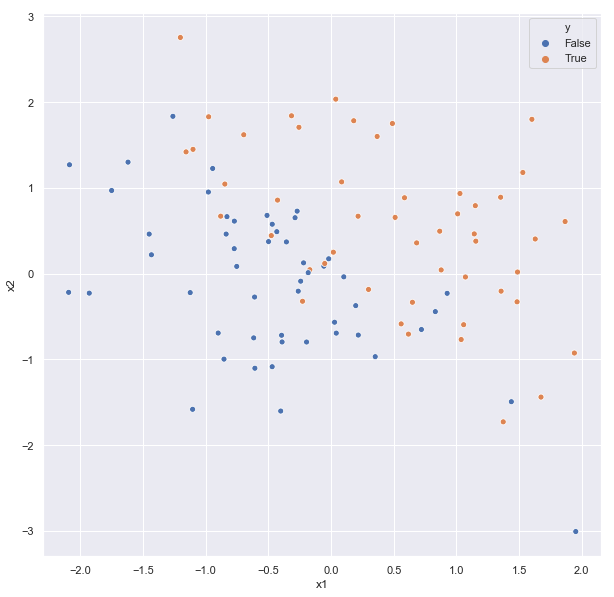

In [253]:
# Generate some data which is almost linearly seperable
x = np.random.normal(0, 1, (100,2))
y = (((x.sum(axis=1) - x.sum(axis=1).mean()) + np.random.normal(0, 0.5, 100)) > 0).reshape(-1, 1)
df = pd.DataFrame(x, columns=['x1', 'x2'])
df['y'] = y
# Add intercept term to x for convenience of notation
i = np.repeat(1, x.shape[0]).reshape(-1,1)
X = np.hstack([i,x])
# Plot the data
sns.scatterplot(x='x1',y='x2',hue='y',data=df)

### Model

We seek a to model the posterior probabilities of the classes, we would like our model to: 
- Be a linear function in `X`
- Produce **probabilites**, that is the numbers output by the model for a given input `xi` must:
    - Sum to one
    - Remain in the interval `[0,1]`

Logistic/Sigmoid, Odds, Log-Odds:

\begin{align}
p(\mathbf{X}) & = \frac{e^{\beta \mathbf{X}}}{1 + e^{\beta \mathbf{X}}} \\
e^{\beta \mathbf{X}} & = \frac{p(\mathbf{X})}{1 - p(\mathbf{X})} \\
\beta \mathbf{X} & = log\Bigg( \frac{p(\mathbf{X})}{1 - p(\mathbf{X)}} \Bigg)
\end{align}

In [328]:
def p(X, beta):
    num = np.exp(X @ beta)
    denom = 1 + np.exp(X @ beta)
    return num / denom

### Maximum Likelihood Formulation 

We seek coefficients to maximise the likelihood of the observed data:

\begin{align}
likelihood(\theta) = \prod_{i=1}^N \mathit{p}_k(\mathit{x}_i ; \theta) \\
\end{align}

Which is equivalent to maximising the log-likelihood (ℓ):

\begin{align}
\ell(\theta)= \sum_{i=1}^N log(\mathit{p}_k(\mathit{x}_i ; \theta))
\end{align}

In the case of `k=2`:

\begin{align}
\ell(\beta) &= \sum_{i=1}^N\{ \mathit{y}_i log(p(\mathit{x}_i;\beta)) + (1 - \mathit{y}_i) log(1 - p(\mathit{x}_i;\beta)) \} \\
&= \sum_{i=1}^N \{ \mathit{y}_i \beta^T \mathit{x}_i - log(1 + e^{\beta^T \mathit{x}_i})\}
\end{align}

Differentiating with respect to β:

- **X** is the `N by (p + 1)` data matrix (with  column of ones for the intercept paramater appended)
- **p** is the `N by 1` vector of fitted probabilites
- **y** is the `N by 1` vector of labels

\begin{align}
\frac{\partial \ell(\beta)}{\partial \beta} &= \sum_{i=1}^N \mathit{x}_i (\mathit{y}_i - p(\mathit{x}_i;\beta)) \\
&= \mathbf{X}^T(\mathbf{y} - \mathbf{p})
\end{align}

Setting the derivative above to zero yields the *score equations* of which there are `p + 1`; the partial derivative with respect to each predictor and an additional one for the intercept. We now seek to solve these equations for β.

#### Gradient Ascent

In [345]:
def partial_likelihood_wrt_beta(X, y, beta):
    ps = p(X, beta)
    return X.T @ (y - ps)

def gradient_ascent(x, y, alpha, n_iter=100):
    i = 0
    beta = np.zeros((3,1))
    while i < n_iter:
        partial = partial_likelihood_wrt_beta(X, y, beta)
        beta = beta + (alpha * partial)
        i += 1
    return beta

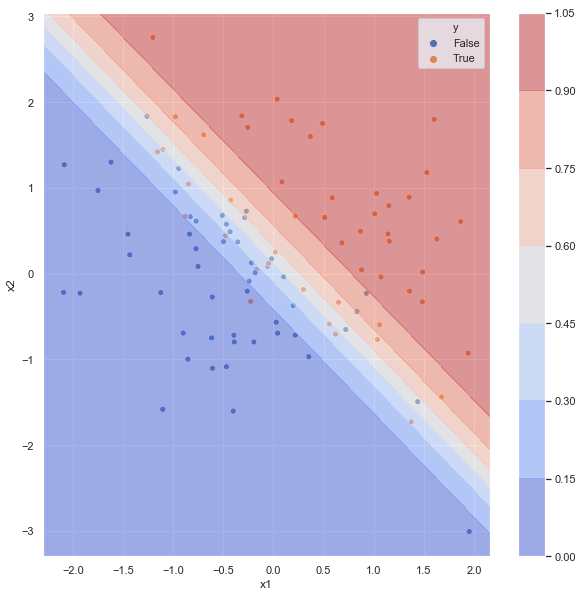

In [346]:
# fit parameters with gradient ascent
beta = gradient_ascent(X, y, 0.01, 1000)

# plot probability contours
ax = sns.scatterplot(x='x1',y='x2',hue='y',data=df)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
xx1 = np.linspace(x_min, x_max, 100)
xx2 = np.linspace(y_min, y_max, 100)
xx1, xx2 = np.meshgrid(xx1, xx2)
grid_X = np.vstack([np.repeat(1, xx1.ravel().shape[0]) ,xx1.ravel(), xx2.ravel()]).T
zz = p(grid_X, beta).reshape(xx1.shape)
plt.contourf(xx1, xx2, zz, cmap='coolwarm', alpha=0.5)
plt.colorbar()

#### Newton-Raphson

We require the Hessian:
- **W** is an `N by N` diagonal matrix with `ith` diagonal element `p(xi;β)(1 - p(xi;β))`

\begin{align}
\frac{\partial^2 \ell(\beta)}{\partial \beta \partial \beta^T} &= - \sum_{i=1}^N \mathit{x}_i \mathit{x}_i^T p(\mathit{x}_i;\beta) (1 - p(\mathit{x}_i;\beta)) \\
&= -\mathbf{X}^T \mathbf{W} \mathbf{X}
\end{align}

An interation of Newton-Raphson is thus:
- In the last line the newton step is re-expressed as a weighted least squares step, where `z` is the *adjusted response*.

\begin{align}
\mathbf{z} = \mathbf{X} \beta^{old} + \mathbf{W}^{-1}(\mathbf{y} - \mathbf{p})
\end{align}

\begin{align}
\beta^{new} &= \beta^{old} - \Bigg(\frac{\partial^2 \ell(\beta)}{\partial \beta \partial \beta^T}\Bigg)^{-1} \frac{\partial \ell(\beta)}{\partial \beta} \\
&= \beta^{old} + (\mathbf{X}^T \mathbf{W} \mathbf{X})^{-1} \mathbf{X}^T(\mathbf{y} - \mathbf{p}) \\
&= (\mathbf{X}^T \mathbf{W} \mathbf{X})^{-1} \mathbf{X}^T \mathbf{W} \mathbf{z}
\end{align}

This formulation is known as iteratively reweighted least squares (IRLS), where each iteration solves the weighted squares problem:

\begin{align}
\beta^{new} \leftarrow argmin_{\beta}(\mathbf{z} - \mathbf{X}\beta)^T \mathbf{W}(\mathbf{z} - \mathbf{X\beta})
\end{align}

In [319]:
def gen_W(X, beta):
    return np.diag((p(X, beta) * (1 - p(X, beta))).T[0])

def gen_z(X, beta, y, W):
    return (X @ beta) + np.linalg.inv(W) @ (y - p(X, beta))

def newton_raphson(X, y, n_iter=100):
    i = 0
    beta = np.zeros((3,1))
    while i < n_iter:
        W = gen_W(X, beta)
        z = gen_z(X, beta, y, W)
        beta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ z
        i += 1
    return beta

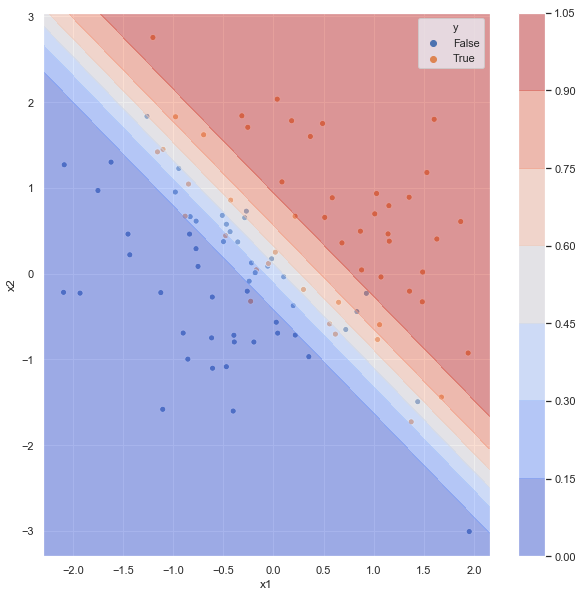

In [320]:
# fit parameters with Newton-Raphson
beta = newton_raphson(X, y, 1000)

# plot probability contours
ax = sns.scatterplot(x='x1',y='x2',hue='y',data=df)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
xx1 = np.linspace(x_min, x_max, 100)
xx2 = np.linspace(y_min, y_max, 100)
xx1, xx2 = np.meshgrid(xx1, xx2)
grid_X = np.vstack([np.repeat(1, xx1.ravel().shape[0]) ,xx1.ravel(), xx2.ravel()]).T
zz = p(grid_X, beta).reshape(xx1.shape)
plt.contourf(xx1, xx2, zz, cmap='coolwarm', alpha=0.5)
plt.colorbar()

In [361]:
### TODO
# - k = N
# - discussion of choice of optimisation algo - https://arxiv.org/pdf/1406.2572.pdf
# - benchmarking